In [1]:
import os
import sys
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import sklearn as sk
import math
import statistics
from datetime import datetime
import collections

from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

 check/enable "table of content" in the nbextensions config.

In [2]:
!conda install -c conda-forge jupyter_contrib_nbextensions

Solving environment: done

# All requested packages already installed.



# **DATA SET**

In [3]:
df = pd.read_csv('movielens-100k-dataset/ml-100k/udata.csv', 
                 sep=";", header=0, engine="python")

user = pd.read_csv('movielens-100k-dataset/ml-100k/uuser.csv', 
                   sep=";", header=0, engine ="python")

genre = pd.read_csv('movielens-100k-dataset/ml-100k/ugenre.csv', 
                    sep=";", header=0, engine = "python")

## preprocessing the user dataset

In [4]:
user.head(2)

,id,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [5]:
user.shape

(943, 5)

 We consider "gender" as the sensitive attribute. F is the protected value and M is the unprotected value.

## defining the protected and unprotected group

In [6]:
user['is_pro'] = 0
for i, row in user.iterrows():
    if row['gender'] == 'F':
        user.loc[i,'is_pro'] = 1
user.head(3)

,id,age,gender,occupation,zipcode,is_pro
0,1,24,M,technician,85711,0
1,2,53,F,other,94043,1
2,3,23,M,writer,32067,0


In [7]:
user[['id', 'is_pro']].head()

,id,is_pro
0,1,0
1,2,1
2,3,0
3,4,0
4,5,1


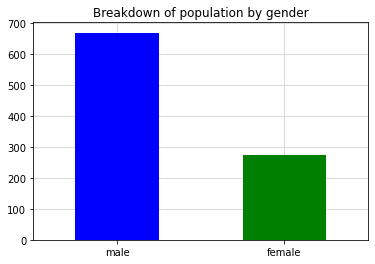

In [8]:
# preliminary stats
breakbygender = pd.value_counts(user['is_pro'].values,sort=False)
breakbygender
ax = breakbygender.plot(kind='bar', title='Breakdown of population by gender', color=['b', 'g'])
ax.grid(True, color='lightgray', linestyle='-')
ax.set_xticks([0,1])
ax.set_xticklabels(['male', 'female'], rotation='horizontal')
ax.set_axisbelow(True)


## pro & unpro groups finalized

In [9]:
global pro_users
global unpro_users

In [10]:
pro_users = []
unpro_users = []

for i, row in user[['id', 'is_pro']].iterrows():
    if row['is_pro'] == 1:
        pro_users.append(row['id'])
    else:
        unpro_users.append(row['id'])
        
print('protected users', len(pro_users))
print('unprotected users', len(unpro_users))

protected users 273
unprotected users 670


# **CONSUMER-SIDE FAIRNESS METRICS**


- 0: uid, 1: iid, 2:r_ui, 3: est

- g: disadvantaged, -g: advantaged

## common functions

### calcualting the average rating (estimated or true rating)

In [12]:
def avg_score(df_i, itemid, users, est=False): 
    if est:
        pred_type = 'est'
    else:
        pred_type = 'r_ui'
    
    f_df = df_i.loc[(df_i['uid']).isin(users), pred_type]
    
    return f_df.mean()


### separating the predictions

In [13]:
def seperate_preds(preds):
    
    pro_preds = []
    unpro_preds = []

    for row in preds:
        if row.uid in pro_users:
            pro_preds.append(row)
        else:
            unpro_preds.append(row)
            
    return pro_preds, unpro_preds


### pro & unpro count function

In [14]:
def pro_unpro_count(preds):
    
    pros= []
    unpros =[]
    
    for row in preds:
        if row.uid in pro_users:
            pros.append(row.uid)
        else:
            unpros.append(row.uid)
            
    return np.unique(pros), np.unique(unpros)
    

### is this an eligible item?

- ISSUE: if an item is not rated by a group, NaN will be returned as the output for average rating of that group and as the final output. To avoid this issue, we calculate the consumer-side fairness metrics over items that were rated by both groups.
- NOTE: Therefore all the metrics below are calcualted over the common items.

In [130]:
def is_i_eligible(item_df):
    
    # if there is only one rating, return False
    cond_a = len(item_df) >= 2
    
    if cond_a:
        # if this item has ratings from both the protected and unprotected user groups
        cond_b = np.any(np.any((item_df['uid']).isin(pro_users)) and
                       np.any((item_df['uid']).isin(unpro_users)))
        return cond_b
    
    return False


## Value Unfairness

In [131]:
def value_unfairness(p_df):
    
    '''
    value unfairness, measures inconsistency in signed estimation error across the user types
    
    Value unfairness occurs when one class of user is consistently given higher or lower predictions
    than their true preferences. If the errors in prediction are evenly balanced between overestimation
    and underestimation or if both classes of users have the same direction and magnitude of error, the
    value unfairness becomes small. Value unfairness becomes large when predictions for one class
    are consistently overestimated and predictions for the other class are consistently underestimated.
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid']):

        item_df = p_df[p_df['iid'] == itemid]
        
        # skip the item that doesn't have more than 2 ratings or ratings from both pro & unpro
        if not is_i_eligible(item_df):
            continue

        e_g_y = avg_score(item_df, itemid, pro_users, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users, est=False)
        
        sum_err += abs((e_g_y - e_g_r) - (e_ng_y - e_ng_r))
    
    # if non of the items had any ratings. itt's a rare condition.
    if sum_err == 0:
        return 'ERROR: non of the items had any ratings.'
        
    return sum_err/np.unique(p_df['iid']).size
    

## Absolute Unfairness

In [132]:
def abs_unfairness(p_df):
    
    '''
    absolute unfairness measures inconsistency in absolute estimation error across user types
    
    Absolute unfairness is unsigned, so it captures a single statistic representing the quality of prediction 
    for each user type. If one user type has small reconstruction error and the other user type has large 
    reconstruction error, one type of user has the unfair advantage of good recommendation, while the
    other user type has poor recommendation.
    
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid']):

        item_df = p_df[p_df['iid'] == itemid]
        
        # skip the item that doesn't have more than 2 ratings or ratings from both pro & unpro
        if not is_i_eligible(item_df):
            continue

        e_g_y = avg_score(item_df, itemid, pro_users, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users, est=False)
        
        sum_err += abs(abs(e_g_y - e_g_r) - abs(e_ng_y - e_ng_r))
        
    # if non of the items had any ratings. itt's a rare condition.
    if sum_err == 0:
        return 'ERROR: non of the items had any ratings.'
    
    return sum_err/np.unique(p_df['iid']).size


## Under-estimation Unfairness

In [134]:
def underestimation_unfairness(p_df):
    
    '''
    underestimation unfairness measures inconsistency in how much the predictions underestimate the true ratings
    
    Underestimation unfairness is important in settings where missing recommendations are more critical
    than extra recommendations. 
    
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid']):

        item_df = p_df[p_df['iid'] == itemid]
        
        # skip the item that doesn't have more than 2 ratings or ratings from both pro & unpro
        if not is_i_eligible(item_df):
            continue

        e_g_y = avg_score(item_df, itemid, pro_users, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users, est=False)
        
        sum_err += abs(max([0,(e_g_r - e_g_y)]) - max([0,(e_ng_r - e_ng_y)]))
        
    # if non of the items had any ratings. itt's a rare condition.
    if sum_err == 0:
        return 'ERROR: non of the items had any ratings.'
        
    return sum_err/np.unique(p_df['iid']).size


## Over-estimation Unfairness

In [135]:
def overestimation_unfairness(p_df):
    
    '''
    Overestimate unfairness measures inconsistency in how much the predictions overestimate the true ratings
    
    Overestimation unfairness may be important in settings where users may be overwhelmed by recommendations, so providing too many recommendations would be especially detrimental. For example,
    if users must invest large amounts of time to evaluate each recommended item, overestimating
    essentially costs the user time. Thus, uneven amounts of overestimation could cost one type of user
    more time than the other.
    
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid']):

        item_df = p_df[p_df['iid'] == itemid]
        
        # skip the item that doesn't have more than 2 ratings or ratings from both pro & unpro
        if not is_i_eligible(item_df):
            continue

        e_g_y = avg_score(item_df, itemid, pro_users, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users, est=False)
        
        sum_err += abs(max([0,(e_g_y - e_g_r)]) - max([0,(e_ng_y - e_ng_r)]))
        
    # if non of the items had any ratings. itt's a rare condition.
    if sum_err == 0:
        return 'ERROR: non of the items had any ratings.'   

    return sum_err/np.unique(p_df['iid']).size


## Non Parity

In [136]:
def non_parity(p_df):
    
    '''
    nonparity measure based on the regularization term introduced by Kamishima et al. 
    can be computed as the absolute difference between the overall average ratings of disadvantaged users 
    and those of advantaged users.
    '''
    e_g_y = p_df.loc[(p_df['uid']).isin(pro_users), 'est'].mean()
    e_ng_y = p_df.loc[(p_df['uid']).isin(unpro_users), 'est'].mean()
    
    
    return abs(e_g_y - e_ng_y)
    

## Miscalibration unfairness

In [166]:
# %run miscalibration_error.ipynb

### data pre-processing for miscalibration unfairness

In [167]:
col = ["movie id",'movie title', 'release date', 'video release date', 'IMDb URL',
           'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 
           'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
           'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

uitem = pd.read_csv('movielens-100k-dataset/ml-100k/uitem.csv', sep=";", skiprows=1,
                    engine = "python", names=col)

uitem.drop(['movie title', 'release date', 'video release date', 'IMDb URL'],
           axis='columns', inplace=True)
# print(uitem.head(2))

p_g_i = np.array(uitem)
# the first column is the movie ids

# sum of all p_g_i (excluding the first column which is the item id)
vect = np.sum(p_g_i[:,1:], axis=1)[:,None]


global p_g_i_final

p_g_i_final = p_g_i[:,1:]/vect[:]
# p(g|i) is required to calculate the probability of each genre given a movie


#### inner-id to outer-id conversion

NOTE: inner id (index) to movie id

In [229]:
global mvid_to_inx
global inx_to_mvid

mvid_to_inx = {}
inx_to_mvid = {}

for i, mvid in enumerate(np.unique(uitem['movie id'])):
    mvid_to_inx[mvid] = i
    inx_to_mvid[i] = mvid
    

### KL Divergence

In [228]:
def KullbackLeiblerDivergence(interactDist, recommendedDist):
    import numpy as np
    
    alpha = 0.01 
    # not really a tuning parameter, 
    # it's there to make the computation more numerically stable.
    
    klDive = 0.0
    
    # over all the genres
    for i in range(len(interactDist)):
        # By convention, 0 * ln(0/a) = 0, so we can ignore keys in q that aren't in p
        if interactDist[i] == 0.0:
            continue
            
        # if q = recommendationDist and p = interactedDist, q-hat is the adjusted q.
        # given that KL divergence diverges if recommendationDist or q is zero, 
        # we instead use q-hat = (1-alpha).q + alpha . p
        # q(g|u) & p(g|u)
        recommendedDist[i] = (1 - alpha) * recommendedDist[i] + alpha * interactDist[i]
        
        klDive += interactDist[i] * np.log2(interactDist[i] / recommendedDist[i])

    return klDive

### calculate profile distribution

In [227]:
def ComputeGenreDistribution(item_list, p_g_i_final):
    '''
    either we pass the list of items from the training data/obsereved movies for each user,
    or we pass the list of recommended items to a user to create the distribution
    '''
    # turn the item ids to item indices, then retrieve them
    indx_list = [mvid_to_inx[itemid] for itemid in item_list]
    
    return p_g_i_final[indx_list,:].sum(axis=0) / len(indx_list)


### miscalibration error function

NOTE: the previous fairness metrics were calculated over items, but here calibration is calculated over users.

NOTE: We might be able to use this metric to understand the affect of data minimization.

In [230]:
def miscalibration(train_df, rec_df, p_g_i_final):

    # get the list of users
    userlist = np.unique(train_df['user'])
    
    sum_kl_div = 0.0
    for userid in userlist:
        
        # what are the items that the user has rated in the past?
        interactedItems = train_df.loc[train_df['user']== userid, 'item'].tolist()
        
        # what are the items that has been recommended to a certain user?
        recommendedItems = rec_df.loc[rec_df['uid'] == userid,'iid'].tolist()

        # calculating the genre distributions
        interactedDist = ComputeGenreDistribution(interactedItems, p_g_i_final)
        recommendedDist = ComputeGenreDistribution(recommendedItems, p_g_i_final)

        sum_kl_div += KullbackLeiblerDivergence(interactedDist, recommendedDist)
        
    return sum_kl_div/len(userlist)
       

In [231]:
# miscalibration(df, preds_al_df, p_g_i_final)

0.7549552624539556

In [ ]:
# miscalibration for pro and unpro users?????

## PPR or statistical parity

How many ratings do we have alltogether?

In [34]:
print('# of ratings', len(df['rating'].tolist()))

# of ratings 100000


# **ACTIVE LEARNING**

## defining the # of iterations (big, medium and small sample sizes)

In [35]:
# 16 gaps of data
data_big = []
for i in range(17):
    data_big.append((i*5000))
data_big[0] = 1


data_med = []
for i in range(101):
    data_med.append((i*200))
data_med[0] = 1


data_sm = []
for i in range(601):
    data_sm.append((i*5))
data_sm[0] = 1

NOTE: We can't go up to 100,000 when we define the gaps below, since we take 20,000 as the test set and we can only go up to 80,000. We create three separate experiments, the ones with smaller gaps are to look at the changes closely!

## data prep / rec algo

In [36]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))


# We'll use the famous SVD algorithm.
algo = SVD()


# Active learning 4 - Attention Based Popularity
df_1 = df.pivot(index = 'user', columns ='item', values = 'rating')

df_numpy = df_1.values

In [37]:
print('#user', '#item')
print(df_numpy.shape)


#user #item
(943, 1682)


In [38]:
print('#item','#user')
print(df_numpy.T.shape)


#item #user
(1682, 943)


## a fixed test set for all the strategies

In [39]:
# Return a random sample of user, item, rating rows
test = df.sample(n = 20000)

algo = SVD()
algoran = SVD()


## <font color='cyan'> **Attention Based - Popularity Based** </font>

Attention-based. This group of strategies focus on selecting the
items that have received the highest “attention” among the
users. Such items are likely to be known by the users, and
therefore they can be rated by them. Hence, these strategies
usually add a lot of ratings. These strategies are
simple and easy to implement and they were introduced
in the initial attempts to solve the cold start problem in
collaborative filtering. They are considered as baseline
strategies

Popularity: selects the most popular items, i.e., those
with the highest number of ratings. It is very likely that the
users are able to rate these items and consequently the
size of the rating dataset can be increased. However,
popular items are typically widely liked by the users.
Therefore, their ratings usually bring little information
to the system. Moreover, this strategy may cause the
*prefix bias*, i.e., the system trained with ratings for
popular items tend also to recommend these popular
items, making them even more popular.

### ordering the items based on their popularity

In [40]:
tstart = datetime.now()
numberCol = []

# for every item
for column in df_numpy.T:
    
    i = 0
    for eachValue in column:
        
        # if the rating existed
        # all the ratings are whole values,
            # but this should change for other ratings
        if (eachValue == 1 or eachValue == 2 or eachValue == 3 
        or eachValue == 4 or eachValue == 5):
            i=i+1
            
    # how many ratings do we have for each item?
    numberCol.append(i)


item = np.array(numberCol)
item = pd.DataFrame(item, columns = ["item"])

# take only the most popular item
# we have the count of ratings for each item, now sort them!
item = item.sort_values(by=["item"], ascending = False)
index = item.index.tolist()

# create a training set, which consists of the same user/item/rating data,
# but is sorted based on item popularity
trainact = pd.DataFrame(columns=['user','item','rating'])

for i in index:
    trainact = trainact.append(df.loc[df['item']==i],ignore_index = True)

trainact = trainact.drop_duplicates(keep ='first')


### where to keep the results

In [187]:
# general RMSE
rmse_al = [] # active learning
rmse_ran = [] # random


# seperating the protected and unprotected groups
# active learning
rmse_al_pro = []
rmse_al_unpro = []
#random
rmse_ran_pro = []
rmse_ran_unpro = []


# value unfairness
vu_al = []
vu_ran = []

# non parity
np_al = []
np_ran = []

# absolute value unfairness
au_al = []
au_ran = []

# over estimation unfairness
ou_al = []
ou_rand = []

#under estimation unfairness
uu_al = []
uu_rand = []

miscalib_al = []
miscalib_rand = []
# pro & unpro difference
miscalib_al_pro = []
miscalib_al_unpro = []


Here we separate the test set and keep it like this for all the experiments. We create a random test sample from the original data. The collected datapoints are user, item, rating.
Originally, I would get a test sample at every iteration, inside the for loop. But it was contributing to the randomness of the outcome a lot. So, I took it outside the loop.

### popularity-based AL algorithm

Q: how do we sample so we can keep the RMSE difference between the pro and unpro very low? and the RMSE generally low?

In [ ]:
for i in data_big:
    print('sample %i data point(s)...' %i)
# for i in data_med:
# for i in data_sm:

#     algo = SVD()
#     algoran = SVD()

    # If we have 2 exactly the same items, keep=False removes both.
    # Here we are removing the test from the train.
    trainact1 = pd.concat([test, trainact]).drop_duplicates(keep=False) 
    trainact1 = trainact1.head(i)
    # Every time pick i item from the whole data, acttrain has a different ordering

    
    # keep=false, drop all duplicates
    # df is the original data
    train = pd.concat([df, test]).drop_duplicates(keep=False)
#     train = train.sample(n = i) # pick i item from the train randomly
    #'to make the passive strategy in harmony with the active strategy, we make the test set cumulative.'
    train = train.head(i)

    trainsetact = Dataset.load_from_df(trainact1[['user', 'item', 'rating']],
                                       reader).build_full_trainset()
    trainset = Dataset.load_from_df(train[['user', 'item', 'rating']],
                                    reader).build_full_trainset()
    testset = Dataset.load_from_df(test[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()

    
    ################### fitting the AL sample to SVD ###################
    algo.fit(trainsetact)
    predictions_al = algo.test(testset)

    # general RMSE
    rmse_al.append(accuracy.rmse(predictions_al, verbose=False))
    
    # pro & unpro RMSE
    pro_pr_al, unpro_pr_al = seperate_preds(predictions_al)    
    rmse_al_pro.append(accuracy.rmse(pro_pr_al, verbose=False))
    rmse_al_unpro.append(accuracy.rmse(unpro_pr_al, verbose=False))
    
    
    # pro & unpro count
    # pro_c, unpro_c = pro_unpro_count(predictions)
    
    
    ##################### fitting the random sample to svd ###################
    algoran.fit(trainset)
    predictionsran = algoran.test(testset)

    # RMSE
    rmse_ran.append(accuracy.rmse(predictionsran, verbose=False))
    
    # pro & unpro RMSE
    pro_pr_ran, unpro_pr_ran = seperate_preds(predictionsran)    
    rmse_ran_pro.append(accuracy.rmse(pro_pr_ran, verbose=False))
    rmse_ran_unpro.append(accuracy.rmse(unpro_pr_ran, verbose=False))

    
    ## consumer-side fairness metrics
    # fairness metrics
    preds_ran_df = pd.DataFrame(predictionsran)
    preds_al_df = pd.DataFrame(predictions_al)
    
    # value unfairness
    vu_ran.append(value_unfairness(preds_ran_df))
    vu_al.append(value_unfairness(preds_al_df))
    
    # non-parity
    np_ran.append(non_parity(preds_ran_df))
    np_al.append(non_parity(preds_al_df))
    
    # absolute unfairness
    au_ran.append(abs_unfairness(preds_ran_df))
    au_al.append(abs_unfairness(preds_al_df))
    
    # over-estimation unfairness
    ou_rand.append(overestimation_unfairness(preds_ran_df))
    ou_al.append(overestimation_unfairness(preds_al_df))
    
    #under-estimation unfairness
    uu_rand.append(underestimation_unfairness(preds_ran_df))
    uu_al.append(underestimation_unfairness(preds_al_df))
    
    
    
    ###########################INCOMPLETE????????
    # miscalibration error
    miscalib_rand.append(miscalibration(df, preds_ran_df, p_g_i_final))
    miscalib_al.append(miscalibration(df, preds_al_df, p_g_i_final))
    
    # how is it different with the general data?
    miscalib_al_pro.append(miscalibration(df, ))
    miscalib_al_unpro.append()
    
    # how is it different with the df of pro or unpro?
    
    
tend = datetime.now()    
print("\n Active learning in ms : \n")
print(tend-tstart)

sample 1 data point(s)...


### metrics and plots

#### Pro & Unpro RMSE Difference 

In [174]:
rmse_diff_pop = [a-b for a, b in zip(rmse_al_pro, rmse_al_unpro)]
rmse_diff_ran = [a-b for a, b in zip(rmse_ran_pro, rmse_ran_unpro)]


usually the rmse of the protected is lower than the unprotected group. 
Therefore, if the value is still positive, it means that the RMSE of the unprotected is higher(bad). The bigger the value, it shows the gap between these two groups and how much we're unfair to the protected. If the value is negative, it means that we're being unfair to the protected group.
So, the closer it is to zero, the closer the more fair the results.

#### RMSE plot - Attention based popularity & Random

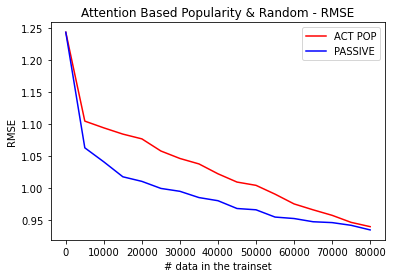

In [175]:
plt.plot(data_big, rmse_al,'r')
plt.plot(data_big, rmse_ran,'b')

# plt.plot(data_med, rmse_al,'r')
# plt.plot(data_med, rmse_ran,'b')

# plt.plot(data_sm, rmse_al,'r')
# plt.plot(data_sm, rmse_ran,'b')

# plt.axis([0, 20000, 0.5, 2.0])
plt.title('Attention Based Popularity & Random - RMSE')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['ACT POP', 'PASSIVE'], loc='best')

# plt.show()
plt.savefig('./figures/july9/Attention Based Popularity & Random - RMSE - big gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - RMSE - medium gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - RMSE.png')


#### Pro vs Unpro RMSE

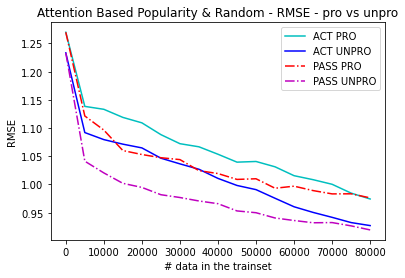

In [176]:
plt.plot(data_big,rmse_al_pro,'c')
plt.plot(data_big,rmse_al_unpro,'b')

plt.plot(data_big,rmse_ran_pro,'r-.')
plt.plot(data_big,rmse_ran_unpro,'m-.')


# plt.plot(data_med,rmse_al_pro,'c')
# plt.plot(data_med,rmse_al_unpro,'b')

# plt.plot(data_med,rmse_ran_pro,'r-.')
# plt.plot(data_med,rmse_ran_unpro,'m-.')


# plt.plot(data_sm,rmse_al_pro,'c')
# plt.plot(data_sm,rmse_al_unpro,'b')

# plt.plot(data_sm,rmse_ran_pro,'r-.')
# plt.plot(data_sm,rmse_ran_unpro,'m-.')


# plt.axis([0, 20000, 0.5, 2.0])
plt.title('Attention Based Popularity & Random - RMSE - pro vs unpro')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['ACT PRO', 'ACT UNPRO', 'PASS PRO', 'PASS UNPRO'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Attention Based Popularity & Random\
- RMSE - pro vs unprov - big gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - RMSE - pro vs unprov - medium gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - RMSE - pro vs unprov - small gaps.png')

#### value unfairness

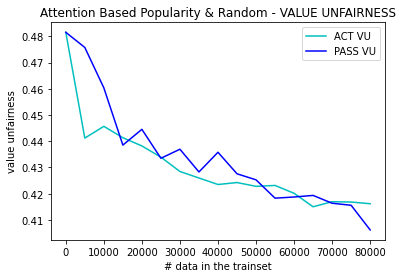

In [177]:
plt.plot(data_big,vu_al,'c')
plt.plot(data_big,vu_ran,'b')

# plt.plot(data_med, vu_al,'c')
# plt.plot(data_med, vu_ran,'b')

# plt.plot(data_sm, vu_al,'c')
# plt.plot(data_sm, vu_ran,'b')

# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Popularity & Random - VALUE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('value unfairness')
plt.legend(['ACT VU', 'PASS VU'], loc='best')

# plt.show()
plt.savefig('./figures/july9/Attention Based Popularity & Random\
- VALUE UNFAIRNESS - big gaps.png')

# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - VALUE UNFAIRNESS - medium gaps.png')

# plt.savefig('./figures/june22/Attention Based Popularity & Random\
# - VALUE UNFAIRNESS - small gaps.png')

#### absolute unfairness

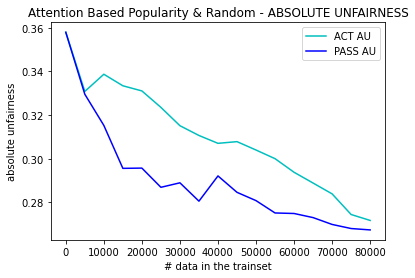

In [178]:
plt.plot(data_big,au_al,'c')
plt.plot(data_big,au_ran,'b')

# plt.plot(data_med,au_al,'c')
# plt.plot(data_med,au_ran,'b')

# plt.plot(data_sm,au_al,'c')
# plt.plot(data_sm,au_ran,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Popularity & Random - ABSOLUTE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('absolute unfairness')
plt.legend(['ACT AU', 'PASS AU'], loc='best')
# plt.show()

plt.savefig('./figures/july9/Attention Based Popularity & Random - \
ABSOLUTE UNFAIRNESS - big gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random - \
# ABSOLUTE UNFAIRNESS - medium gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random - \
# ABSOLUTE UNFAIRNESS - small gaps.png')


#### non parity

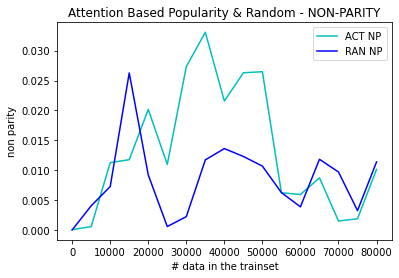

In [179]:
plt.plot(data_big,np_al,'c')
plt.plot(data_big,np_ran,'b')

# plt.plot(data_med,np_al,'c')
# plt.plot(data_med,np_ran,'b')

# plt.plot(data_sm,np_al,'c')
# plt.plot(data_sm,np_ran,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Popularity & Random - NON-PARITY')
plt.xlabel('# data in the trainset')
plt.ylabel('non parity')
plt.legend(['ACT NP', 'RAN NP'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Attention Based Popularity & Random - NON-PARITY - big gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - NON-PARITY - medium gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - NON-PARITY - small gaps.png')

#### over estimation unfairness

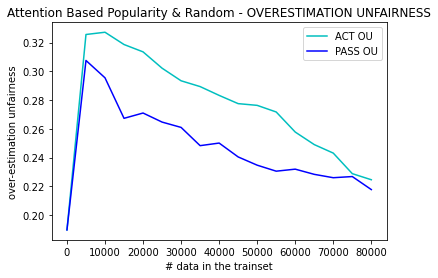

In [180]:
plt.plot(data_big,ou_al,'c')
plt.plot(data_big,ou_rand,'b')

# plt.plot(data_med, ou_al,'c')
# plt.plot(data_med, ou_rand,'b')

# plt.plot(data_sm, ou_al,'c')
# plt.plot(data_sm, ou_rand,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Popularity & Random - OVERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('over-estimation unfairness')
plt.legend(['ACT OU', 'PASS OU'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Attention Based Popularity & Random\
- OVERESTIMATION UNFAIRNESS - big gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - OVERESTIMATION UNFAIRNESS - medium gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - OVERESTIMATION UNFAIRNESS - small gaps.png')


#### under estimation unfairness

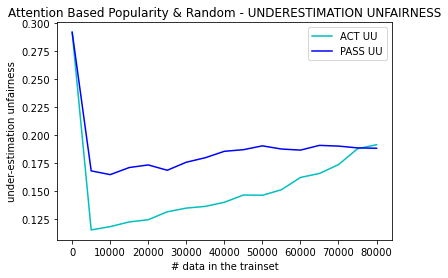

In [181]:
plt.plot(data_big, uu_al,'c')
plt.plot(data_big, uu_rand,'b')

# plt.plot(data_med, uu_al,'c')
# plt.plot(data_med, uu_rand,'b')

# plt.plot(data_sm, uu_al,'c')
# plt.plot(data_sm, uu_rand,'b')

# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Popularity & Random - UNDERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('under-estimation unfairness')
plt.legend(['ACT UU', 'PASS UU'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Attention Based Popularity & Random\
- UNDERESTIMATION UNFAIRNESS - big gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - UNDERESTIMATION UNFAIRNESS - medium gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - UNDERESTIMATION UNFAIRNESS - small gaps.png')

#### miscalibration error

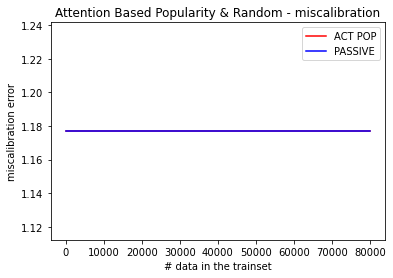

In [182]:
plt.plot(data_big, miscalib_al,'r')
plt.plot(data_big, miscalib_rand,'b')


# plt.axis([0, 20000, 0.5, 2.0])
plt.title('Attention Based Popularity & Random - miscalibration')
plt.xlabel('# data in the trainset')
plt.ylabel('miscalibration error')
plt.legend(['ACT POP', 'PASSIVE'], loc='best')

plt.show()
# plt.savefig('./figures/july9/Attention Based Popularity & Random - RMSE - big gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - RMSE - medium gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - RMSE.png')


In [ ]:
??????????

In [185]:
miscalib_rand[0]


1.1769590094021523

In [186]:
miscalib_al[0]

1.1769590094021523

## <font color='blue'> **Attention Based SQRT(Popularity) * Variance** </font>

This is a “balanced” strategy as it tries to collect many ratings but also taking into account 
their relative informativeness. This is achieved by scoring an item with the square root of the popularity multiplied
by the variance of the item’s ratings. The distribution of the items’ popularity is exponential
while the distribution of the variance is more similar to a normal distribution. 
Indeed, there is a huge difference among the popularity scores of few popular and many
unpopular items. multiplying variance and popularity reduces the weight of popularity. 
Therefore we end up with items that are popular and at the same time have controvertial ratings.

### AL algorithm

In [52]:
# 16 gaps of data
# data = []
# for i in range(101):
#     data.append((i*200))
# data[0] = 1


# A reader is still needed but only the rating_scale param is requiered.
# reader = Reader(rating_scale=(1, 5))


# We'll use the famous SVD algorithm.
# algo = SVD()


# Active learning 4 - Attention Based Square(Popularity) * Variance

# df_1 = df.pivot(index = 'user', columns ='item', values = 'rating')

# df_numpy = df_1.values

np.warnings.filterwarnings('ignore')

df_mask = df_numpy > 0
df_mask = df_mask.astype(int)

# RMSE
rmse_al_popvar = []
rmse_ran_popvar = []

# for fairness metrics
rmse_al_pro_popvar = []
rmse_al_unpro_popvar = []

rmse_ran_pro_popvar = []
rmse_ran_unpro_popvar = []

vu_al_popvar = []
vu_ran_popvar = []

np_al_popvar = []
np_ran_popvar = []

au_al_popvar = []
au_ran_popvar = []

ou_al_popvar = []
ou_rand_popvar = []

uu_al_popvar = []
uu_rand_popvar = []


# Popularity
tstart = datetime.now()

numberCol = []
for column in df_numpy.T:
    i = 0
    for eachValue in column:
        if eachValue == 1 or eachValue == 2 or eachValue == 3 or eachValue == 4 or eachValue == 5:
            i=i+1
    numberCol.append(i)

item_popularity = np.array(numberCol)

item_popularity_normalize = []
for i in range(len(item_popularity)):
    item_popularity_normalize.append((item_popularity[i]-min(item_popularity))/
                                     (max(item_popularity)-min(item_popularity)))

# Variance
colVariance = []
for eachCol in df_numpy.T:
    colVariance.append(np.nanvar(eachCol))

item_variance = np.array(colVariance)


# Product
item = np.sqrt(item_popularity_normalize)*item_variance

item = pd.DataFrame(item, columns = ["item"])


# take only the most popular item
item = item.sort_values(by=["item"], ascending = False)
index = item.index.tolist()

trainact = pd.DataFrame(columns=['user','item','rating'])

for i in index:
    trainact = trainact.append(df.loc[df['item']==i],ignore_index = True)

trainact = trainact.drop_duplicates()

tend = datetime.now()


# this action looks like having a k-fold cross validation
# test = df.sample(n=20000, random_state=1)

for i in data_big:
    print('sample %i data point(s)...' %i)
# for i in data_med:
# for i in data_sm:

#     algo = SVD()
#     algoran = SVD()

#     # this action looks like having a k-fold cross validation
#     test = df.sample(n=20000, random_state=1)

    trainact1 = pd.concat([trainact, test]).drop_duplicates(keep=False)
    trainact1 = trainact1.head(i)

    train = pd.concat([df, test]).drop_duplicates(keep=False)
#     train = train.sample(n = i)
    # making this passive strategy cumulative
    train = train.head(i)

    trainsetact = Dataset.load_from_df(trainact1[['user', 'item', 'rating']], reader).build_full_trainset()
    trainset = Dataset.load_from_df(train[['user', 'item', 'rating']],reader).build_full_trainset()
    testset = Dataset.load_from_df(test[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

    ### active learning ###
    algo.fit(trainsetact)
    predictions_al = algo.test(testset)

    rmse_al_popvar.append(accuracy.rmse(predictions_al, verbose=False))

    # pro & unpro RMSE
    pro_pr_al, unpro_pr_al = seperate_preds(predictions_al)   
    rmse_al_pro_popvar.append(accuracy.rmse(pro_pr_al, verbose=False))
    rmse_al_unpro_popvar.append(accuracy.rmse(unpro_pr_al, verbose=False))
    
    
    ### random ###
    algoran.fit(trainset)
    predictionsran = algoran.test(testset)

    rmse_ran_popvar.append(accuracy.rmse(predictionsran, verbose=False))
    
    
    # pro & unpro RMSE
    pro_pr_ran, unpro_pr_ran = seperate_preds(predictionsran)    
    rmse_ran_pro_popvar.append(accuracy.rmse(pro_pr_ran, verbose=False))
    rmse_ran_unpro_popvar.append(accuracy.rmse(unpro_pr_ran, verbose=False))
    
    
    ##### consumer side fairness metrics
    # fairness metrics
    preds_al_df = pd.DataFrame(predictions_al)
    preds_ran_df = pd.DataFrame(predictionsran)
    
    # value unfairness
    vu_al_popvar.append(value_unfairness(preds_al_df))
    vu_ran_popvar.append(value_unfairness(preds_ran_df))
    
    # non-parity
    np_al_popvar.append(non_parity(preds_al_df))
    np_ran_popvar.append(non_parity(preds_ran_df))
    
    # absolute unfairness
    au_al_popvar.append(abs_unfairness(preds_al_df))
    au_ran_popvar.append(abs_unfairness(preds_ran_df))
    
    # over-estimation unfairness
    ou_al_popvar.append(overestimation_unfairness(preds_al_df))
    ou_rand_popvar.append(overestimation_unfairness(preds_ran_df))
    
    # under-estimation unfairness
    uu_al_popvar.append(underestimation_unfairness(preds_al_df))
    uu_rand_popvar.append(underestimation_unfairness(preds_ran_df))
    

# print(rmse_al)
print(" Active learning in ms : ")
print(tend-tstart)
# print(rmse_ran)


sample 1 data point(s)...
sample 5000 data point(s)...
sample 10000 data point(s)...
sample 15000 data point(s)...
sample 20000 data point(s)...
sample 25000 data point(s)...
sample 30000 data point(s)...
sample 35000 data point(s)...
sample 40000 data point(s)...
sample 45000 data point(s)...
sample 50000 data point(s)...
sample 55000 data point(s)...
sample 60000 data point(s)...
sample 65000 data point(s)...
sample 70000 data point(s)...
sample 75000 data point(s)...
sample 80000 data point(s)...
 Active learning in ms : 
0:00:07.778185


### metrics and plots

#### Pro & Unpro RMSE difference

In [53]:
rmse_diff_popvar = [a-b for a, b in zip(rmse_al_pro_popvar,
                                        rmse_al_unpro_popvar)]

#### RMSE plot - attention-based sqrt(popularity)*variance

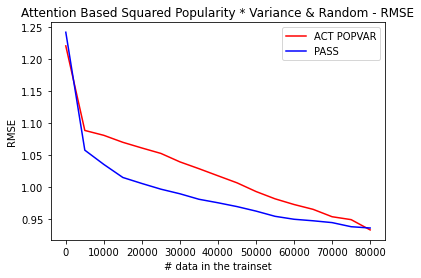

In [54]:
plt.plot(data_big,rmse_al_popvar,'r')
plt.plot(data_big,rmse_ran_popvar,'b')

# plt.plot(data_med,rmse_al,'r')
# plt.plot(data_med,rmse_ran,'b')

# plt.plot(data_sm,rmse_al,'r')
# plt.plot(data_sm,rmse_ran,'b')

# plt.axis([0,20000,0.5,2.0])
plt.title('Attention Based Squared Popularity * Variance & Random - RMSE')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['ACT POPVAR', 'PASS'], loc='best')
# plt.show()

plt.savefig('./figures/july9/Attention Based Squared Popularity * Variance & Random \
- RMSE - big gaps.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - RMSE - medium gaps - fixed test.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - RMSE - small gaps - fixed test.png')


#### Pro vs Unpro RMSE

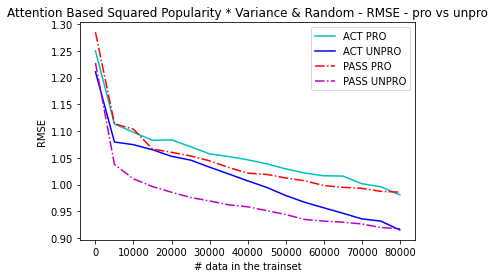

In [55]:
plt.plot(data_big, rmse_al_pro_popvar,'c')
plt.plot(data_big, rmse_al_unpro_popvar,'b')

plt.plot(data_big, rmse_ran_pro_popvar,'r-.')
plt.plot(data_big, rmse_ran_unpro_popvar,'m-.')


# plt.plot(data_med, rmse_al_pro,'c')
# plt.plot(data_med, rmse_al_unpro,'b')

# plt.plot(data_med, rmse_ran_pro,'r-.')
# plt.plot(data_med, rmse_ran_unpro,'m-.')


# plt.plot(data_sm, rmse_al_pro,'c')
# plt.plot(data_sm, rmse_al_unpro,'b')

# plt.plot(data_sm, rmse_ran_pro,'r-.')
# plt.plot(data_sm, rmse_ran_unpro,'m-.')


# plt.axis([0, 20000, 0.5, 2.0])
plt.title('Attention Based Squared Popularity * Variance & Random - RMSE - pro vs unpro')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['ACT PRO', 'ACT UNPRO', 'PASS PRO', 'PASS UNPRO'],
           loc='best')
# plt.show()
plt.savefig('./figures/july9/Attention Based Squared Popularity * Variance & Random \
- RMSE pro vs unpro - big gaps.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - RMSE pro vs unpro - medium gaps - fixed test.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - RMSE pro vs unpro - small gaps - fixed test.png')


#### value unfairness

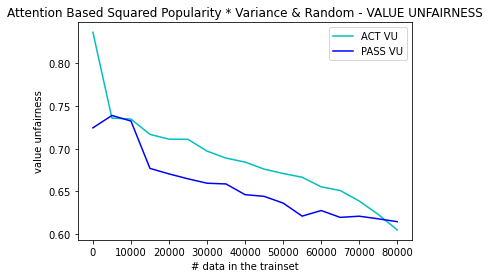

In [56]:
plt.plot(data_big, vu_al_popvar,'c')
plt.plot(data_big, vu_ran_popvar,'b')

# plt.plot(data_med,vu_al,'c')
# plt.plot(data_med,vu_ran,'b')

# plt.plot(data_sm,vu_al,'c')
# plt.plot(data_sm,vu_ran,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Squared Popularity * Variance & Random - VALUE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('value unfairness')
plt.legend(['ACT VU', 'PASS VU'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Attention Based Squared Popularity * Variance & Random \
- VALUE UNFAIRNESS - big gaps.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - VALUE UNFAIRNESS - medium gaps- fixed test.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - VALUE UNFAIRNESS - small gaps- fixed test.png')


#### absolute unfairness

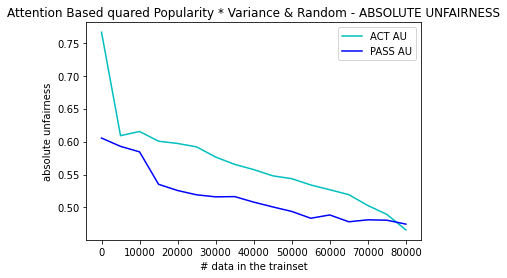

In [57]:
plt.plot(data_big, au_al_popvar,'c')
plt.plot(data_big, au_ran_popvar,'b')

# plt.plot(data_med,au_al,'c')
# plt.plot(data_med,au_ran,'b')

# plt.plot(data_sm,au_al,'c')
# plt.plot(data_sm,au_ran,'b')

# plt.axis([0,80000,0.0,5])
plt.title('Attention Based quared Popularity * Variance & Random - ABSOLUTE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('absolute unfairness')
plt.legend(['ACT AU', 'PASS AU'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Attention Based Squared Popularity * Variance & Random \
- ABSOLUTE UNFAIRNESS - big gaps.png')

# plt.savefig('./figures/july6/Attention Based Squared Popularity * Variance & Random \
# - ABSOLUTE UNFAIRNESS - medium gaps - fixed test.png')

# plt.savefig('./figures/july6/Attention Based Squared Popularity * Variance & Random \
# - ABSOLUTE UNFAIRNESS - small gaps - fixed test.png')


#### non parity

In [ ]:
plt.plot(data_big,np_al,'c')
plt.plot(data_big,np_ran,'b')

# plt.plot(data_med,np_al,'c')
# plt.plot(data_med,np_ran,'b')

# plt.plot(data_sm,np_al,'c')
# plt.plot(data_sm,np_ran,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based sqrt(popularity)*variance & Random - NON-PARITY')
plt.xlabel('# data in the trainset')
plt.ylabel('non parity')
plt.legend(['ACT NP', 'RAN NP'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Attention Based Popularity/variance & Random - NON-PARITY - big gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - NON-PARITY - medium gaps.png')

# plt.savefig('./figures/july6/Attention Based Popularity & Random\
# - NON-PARITY - small gaps.png')

#### over-estimation unfairness

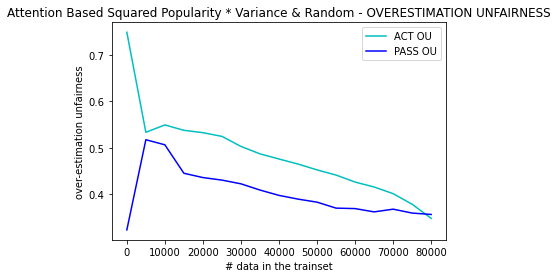

In [58]:
plt.plot(data_big,ou_al_popvar,'c')
plt.plot(data_big,ou_rand_popvar,'b')

# plt.plot(data_med,ou_al,'c')
# plt.plot(data_med,ou_rand,'b')

# plt.plot(data_sm,ou_al,'c')
# plt.plot(data_sm,ou_rand,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Squared Popularity * Variance & Random - OVERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('over-estimation unfairness')
plt.legend(['ACT OU', 'PASS OU'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Attention Based Squared Popularity * Variance & Random \
- OVERESTIMATION UNFAIRNESS - big gaps.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - OVERESTIMATION UNFAIRNESS - medium gaps - fixed test.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random \
# - OVERESTIMATION UNFAIRNESS - small gaps - fixed test.png')



#### underestimation unfairness

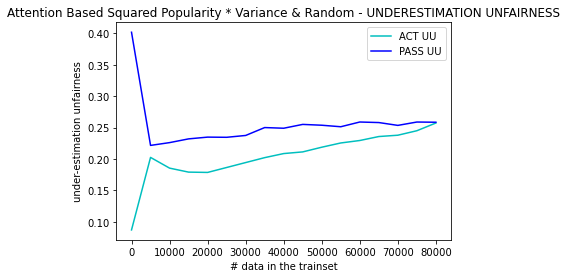

In [59]:
plt.plot(data_big, uu_al_popvar,'c')
plt.plot(data_big, uu_rand_popvar,'b')

# plt.plot(data_med,uu_al,'c')
# plt.plot(data_med,uu_rand,'b')

# plt.plot(data_sm,uu_al,'c')
# plt.plot(data_sm,uu_rand,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Attention Based Squared Popularity * Variance & Random - UNDERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('under-estimation unfairness')
plt.legend(['ACT UU', 'PASS UU'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Attention Based Squared Popularity * Variance & Random\
- UNDERESTIMATION UNFAIRNESS - big gaps.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random\
# - UNDERESTIMATION UNFAIRNESS - medium gaps - fixed test.png')

# plt.savefig('./figures/june22/Attention Based Squared Popularity * Variance & Random\
# - UNDERESTIMATION UNFAIRNESS - small gaps - fixed test.png')


## <font color='magenta'> **Uncertainty Reduction Based on Variance** </font>

Uncertainty-reduction are popular strategies
that select items with controversial or diverse ratings.
The system is supposed to be more uncertain about
the users’ opinion about them and asking a user to rate such
items can bring useful (discriminative) information about the
user’s preferences.

this strategy selects the items with the
highest variance, hence, it favours the items that have
been rated diversely by the users on the assumption that
the variance gives an indication of the uncertainty of the
system about that item’s ratings :
$$Variance(i) = 1/|Ui| \sum
u∈Ui
(rui − ¯ri)2$$

### AL algorithm

In [57]:
# 16 gaps of data

# data = []
# for i in range(101):
#     data.append((i*200))
# data[0] = 1

# A reader is still needed but only the rating_scale param is requiered.

# reader = Reader(rating_scale=(1, 5))

# We'll use the famous SVD algorithm.

# algo = SVD()

# Active learning 3 - Uncertainty Reduction Variance

# df_1 = df.pivot(index = 'user', columns ='item', values = 'rating').fillna(0)

# df_numpy = df_1.values

np.warnings.filterwarnings('ignore')

df_mask = df_numpy > 0
df_mask = df_mask.astype(int)

rmse_al_unvar = []
rmse_ran_unvar = []

# for fairness metrics
rmse_al_pro_unvar = []
rmse_al_unpro_unvar = []

rmse_ran_pro_unvar = []
rmse_ran_unpro_unvar = []

vu_al_unvar = []
vu_ran_unvar = []

np_al_unvar = []
np_ran_unvar = []

au_al_unvar = []
au_ran_unvar = []

ou_al_unvar = []
ou_rand_unvar = []

uu_al_unvar = []
uu_rand_unvar = []

# Calcul variance for each user/item

tstart = datetime.now()

colVariance = []
for eachCol in df_numpy.T:
    colVariance.append(np.nanvar(eachCol))

item = np.array(colVariance)

item = item.reshape(len(item),1)

var = pd.DataFrame(item, columns=['variance'])

# # Find the maximum - most uncertain ratings about item

maximum = float(var.max())
minimum = float(var.min())

trainact = pd.DataFrame(columns=['user','item','rating'])

while maximum > minimum:
    ind = int(var.idxmax())
    trainact = trainact.append(df.loc[df['item']==(ind+1)],
                               ignore_index = True)
    var = var.drop(index = ind)
    maximum = float(var.max())

trainact = trainact.drop_duplicates()

tend = datetime.now()

# test set
# test = df.sample(n = 20000,random_state=1)

for i in data_big:
    print('sample %i data point(s)...'%i)
# for i in data_med:
# for i in data_sm:

#     algo = SVD()
#     algoran = SVD()

    trainact1 = pd.concat([test, trainact]).drop_duplicates(keep=False)
    trainact1 = trainact1.head(i)

    train = pd.concat([df, test]).drop_duplicates(keep=False)
    train = train.sample(n = i)

    trainsetact = Dataset.load_from_df(trainact1[['user', 'item', 'rating']],
                                       reader).build_full_trainset()
    
    trainset = Dataset.load_from_df(train[['user', 'item', 'rating']],
                                    reader).build_full_trainset()
    
    testset = Dataset.load_from_df(test[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()

    #### active learning ####
    algo.fit(trainsetact)
    predictions_al = algo.test(testset)

    rmse_al_unvar.append(accuracy.rmse(predictions_al, verbose=False))

    # pro & unpro RMSE
    pro_pr_al, unpro_pr_al = seperate_preds(predictions_al)   
    rmse_al_pro_unvar.append(accuracy.rmse(pro_pr_al, verbose=False))
    rmse_al_unpro_unvar.append(accuracy.rmse(unpro_pr_al, verbose=False)) 
    
    
    #### random ####
    algoran.fit(trainset)
    predictionsran = algoran.test(testset)

    rmse_ran_unvar.append(accuracy.rmse(predictionsran, verbose=False))
    
    
    # pro & unpro RMSE
    pro_pr_ran, unpro_pr_ran = seperate_preds(predictionsran)    
    rmse_ran_pro_unvar.append(accuracy.rmse(pro_pr_ran, verbose=False))
    rmse_ran_unpro_unvar.append(accuracy.rmse(unpro_pr_ran, verbose=False))
    
    
    ##### consumer side fairness metrics
    # fairness metrics
    preds_al_df = pd.DataFrame(predictions_al)
    preds_ran_df = pd.DataFrame(predictionsran)
    
    # value unfairness
    vu_al_unvar.append(value_unfairness(preds_al_df))
    vu_ran_unvar.append(value_unfairness(preds_ran_df))
        
    # non-parity
    np_al_unvar.append(non_parity(preds_al_df))
    np_ran_unvar.append(non_parity(preds_ran_df))
    
    # absolute unfairness
    au_al_unvar.append(abs_unfairness(preds_al_df))
    au_ran_unvar.append(abs_unfairness(preds_ran_df))
    
    # over-estimation unfairness
    ou_al_unvar.append(overestimation_unfairness(preds_al_df))
    ou_rand_unvar.append(overestimation_unfairness(preds_ran_df))
    
    #under-estimation unfairness
    uu_al_unvar.append(underestimation_unfairness(preds_al_df))
    uu_rand_unvar.append(underestimation_unfairness(preds_ran_df))
    

# print(rmse_al)
print(" Active learning in ms : ")
print(tend-tstart)
# print(rmse_ran)

sample 1 data point(s)...
sample 5000 data point(s)...
sample 10000 data point(s)...
sample 15000 data point(s)...
sample 20000 data point(s)...
sample 25000 data point(s)...
sample 30000 data point(s)...
sample 35000 data point(s)...
sample 40000 data point(s)...
sample 45000 data point(s)...
sample 50000 data point(s)...
sample 55000 data point(s)...
sample 60000 data point(s)...
sample 65000 data point(s)...
sample 70000 data point(s)...
sample 75000 data point(s)...
sample 80000 data point(s)...
 Active learning in ms : 
0:00:05.478135


### metrics and plots

#### Pro and Unpro RMSE Difference

In [58]:
rmse_diff_unvar = [a-b for a, b in zip(rmse_al_pro_unvar,
                                       rmse_al_unpro_unvar)]


The previous methods are all non-personalized! Simpler active learning strategies do not take into account users’ previously expressed ratings and request all the users to rate the same items. We refer to these strategies as nonpersonalized. In this case, the heuristic used for item selection
does not depend on the profile of the individual users.

These strategies can be static or adaptive during time. (for later)

#### RMSE plot - uncertainty-based variance

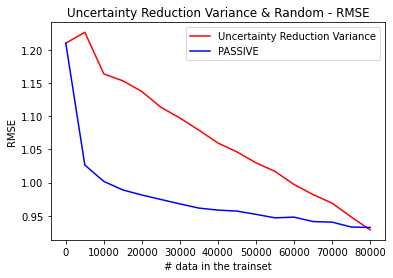

In [59]:

plt.plot(data_big, rmse_al_unvar,'r')
plt.plot(data_big, rmse_ran_unvar,'b')

# plt.plot(data_med, rmse_al,'r')
# plt.plot(data_med, rmse_ran,'b')

# plt.plot(data_sm, rmse_al,'r')
# plt.plot(data_sm, rmse_ran,'b')

# plt.axis([0,20000,0.5,2])
plt.title('Uncertainty Reduction Variance & Random - RMSE')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['Uncertainty Reduction Variance', 'PASSIVE'], loc='upper right')
# plt.show()
plt.savefig('./figures/july6/Uncertainty Reduction Variance & Random \
- RMSE - big gap.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random \
# - RMSE - medium gap - fixed test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random \
# - RMSE - small gap - fixed test.png')


#### pro vs unpro RMSE

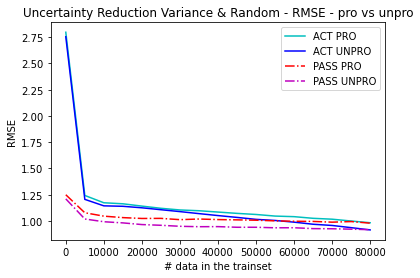

In [64]:
plt.plot(data_big,rmse_al_pro_unvar,'c')
plt.plot(data_big,rmse_al_unpro_unvar,'b')

plt.plot(data_big,rmse_ran_pro_unvar,'r-.')
plt.plot(data_big,rmse_ran_unpro_unvar,'m-.')


# plt.plot(data_med,rmse_al_pro,'c')
# plt.plot(data_med,rmse_al_unpro,'b')

# plt.plot(data_med,rmse_ran_pro,'r-.')
# plt.plot(data_med,rmse_ran_unpro,'m-.')


# plt.plot(data_sm, rmse_al_pro,'c')
# plt.plot(data_sm, rmse_al_unpro,'b')

# plt.plot(data_sm, rmse_ran_pro,'r-.')
# plt.plot(data_sm, rmse_ran_unpro,'m-.')


# plt.axis([0,20000,0.5,2.0])
plt.title('Uncertainty Reduction Variance & Random - RMSE - pro vs unpro')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['ACT PRO', 'ACT UNPRO', 'PASS PRO', 'PASS UNPRO'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Uncertainty Reduction Variance & Random\
- RMSE - pro vs unpro - big gap.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - RMSE - pro vs unpro - medium gap - fixed test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - RMSE - pro vs unpro - small gap - fixed test.png')

#### value unfairness

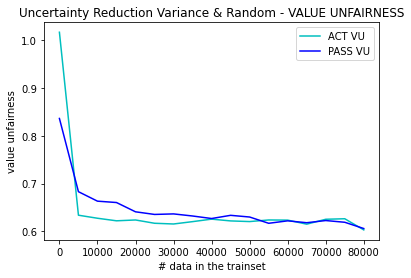

In [65]:
plt.plot(data_big,vu_al_unvar,'c')
plt.plot(data_big,vu_ran_unvar,'b')

# plt.plot(data_med,vu_al,'c')
# plt.plot(data_med,vu_ran,'b')

# plt.plot(data_sm,vu_al,'c')
# plt.plot(data_sm,vu_ran,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Uncertainty Reduction Variance & Random - VALUE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('value unfairness')
plt.legend(['ACT VU', 'PASS VU'], loc='best')
# plt.show()

plt.savefig('./figures/july9/Uncertainty Reduction Variance & Random\
- VALUE UNFAIRNESS - big gap.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - VALUE UNFAIRNESS - medium gap - fixed test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - VALUE UNFAIRNESS - small gap - fixed test.png')

#### absolute unfairness

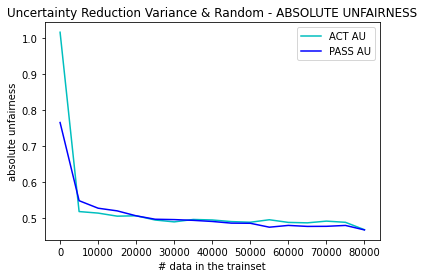

In [66]:
plt.plot(data_big,au_al_unvar,'c')
plt.plot(data_big,au_ran_unvar,'b')

# plt.plot(data_med,au_al,'c')
# plt.plot(data_med,au_ran,'b')

# plt.plot(data_sm,au_al,'c')
# plt.plot(data_sm,au_ran,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Uncertainty Reduction Variance & Random - ABSOLUTE UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('absolute unfairness')
plt.legend(['ACT AU', 'PASS AU'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Uncertainty Reduction Variance & Random\
- ABSOLUTE UNFAIRNESS - big gap.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - ABSOLUTE UNFAIRNESS - medium gap.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - ABSOLUTE UNFAIRNESS - small gap.png')

#### non parity

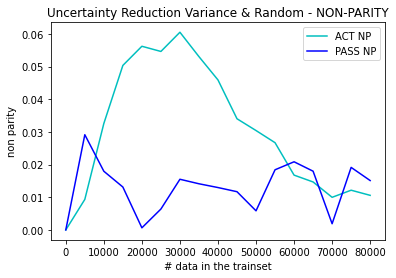

In [67]:
plt.plot(data_big,np_al_unvar,'c')
plt.plot(data_big,np_ran_unvar,'b')

# plt.plot(data_med,np_al,'c')
# plt.plot(data_med,np_ran,'b')

# plt.plot(data_sm, np_al,'c')
# plt.plot(data_sm, np_ran,'b')


# plt.axis([0,20000,0.0,0.25])
plt.title('Uncertainty Reduction Variance & Random - NON-PARITY')
plt.xlabel('# data in the trainset')
plt.ylabel('non parity')
plt.legend(['ACT NP', 'PASS NP'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Uncertainty Reduction Variance & Random\
- NON-PARITY - big gap.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - NON-PARITY - medium gap - fixed test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - NON-PARITY - small gap - fixed test.png')

#### over estimation unfairness

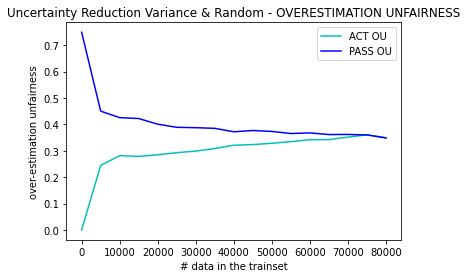

In [70]:
plt.plot(data_big,ou_al_unvar,'c')
plt.plot(data_big,ou_rand_unvar,'b')

# plt.plot(data_med,ou_al,'c')
# plt.plot(data_med,ou_rand,'b')

# plt.plot(data_sm,ou_al,'c')
# plt.plot(data_sm,ou_rand,'b')


# plt.axis([0,80000,0.0,5])
plt.title('Uncertainty Reduction Variance & Random - OVERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('over-estimation unfairness')
plt.legend(['ACT OU', 'PASS OU'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Uncertainty Reduction Variance & Random\
- OVERESTIMATION UNFAIRNESS - big gap.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - OVERESTIMATION UNFAIRNESS - medium gap - fixed test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - OVERESTIMATION UNFAIRNESS - small gap - fixed test.png')

#### under estimation unfairness

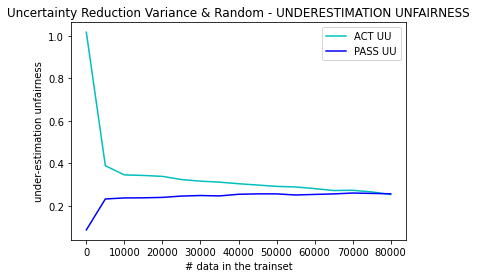

In [71]:
plt.plot(data_big,uu_al_unvar,'c')
plt.plot(data_big,uu_rand_unvar,'b')

# plt.plot(data_med,uu_al,'c')
# plt.plot(data_med,uu_rand,'b')

# plt.plot(data_sm,uu_al,'c')
# plt.plot(data_sm,uu_rand,'b')

# plt.axis([0,80000,0.0,5])
plt.title('Uncertainty Reduction Variance & Random - UNDERESTIMATION UNFAIRNESS')
plt.xlabel('# data in the trainset')
plt.ylabel('under-estimation unfairness')
plt.legend(['ACT UU', 'PASS UU'], loc='best')
# plt.show()
plt.savefig('./figures/july9/Uncertainty Reduction Variance & Random\
- UNDERESTIMATION UNFAIRNESS - big gap.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - UNDERESTIMATION UNFAIRNESS - medium gap - fixed test.png')

# plt.savefig('./figures/june22/Uncertainty Reduction Variance & Random\
# - UNDERESTIMATION UNFAIRNESS - small gap - fixed test.png')

# **ANALYSIS**

 ## RMSE plots of all algorithms

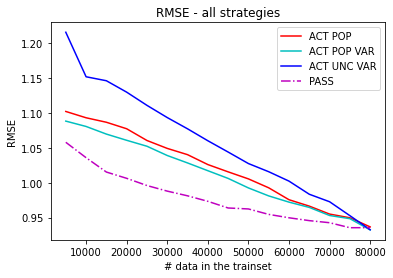

In [74]:
plt.plot(data_big[1:],rmse_al[1:],'r')
plt.plot(data_big[1:],rmse_al_popvar[1:],'c')
plt.plot(data_big[1:],rmse_al_unvar[1:],'b')
plt.plot(data_big[1:],rmse_ran[1:],'m-.')
# plt.plot(data_big,rmse_ran_popvar,'c.')
# plt.plot(data_big,rmse_ran_unvar,'b.')


# plt.axis([0,20000,0.5,2.0])
plt.title('RMSE - all strategies')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['ACT POP','ACT POP VAR', 'ACT UNC VAR', 'PASS', 'PASS POP VAR', 'PASS UN VAR'], loc='upper right')
# plt.show()
plt.savefig('./figures/july9/RMSE - all - big gap1.png')


### RMSEs - PRO

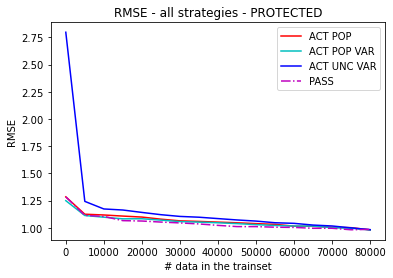

In [75]:
plt.plot(data_big,rmse_al_pro,'r')
plt.plot(data_big,rmse_al_pro_popvar,'c')
plt.plot(data_big,rmse_al_pro_unvar,'b')
plt.plot(data_big,rmse_ran_pro,'m-.')
# plt.plot(data_big,rmse_ran_popvar,'c.')
# plt.plot(data_big,rmse_ran_unvar,'b.')


# plt.axis([0,20000,0.5,2.0])
plt.title('RMSE - all strategies - PROTECTED')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['ACT POP','ACT POP VAR', 'ACT UNC VAR', 'PASS', 'PASS POP VAR', 'PASS UN VAR'], loc='upper right')
# plt.show()
plt.savefig('./figures/july9/RMSE - all - big gap2.png')


### RMSE - UNPRO

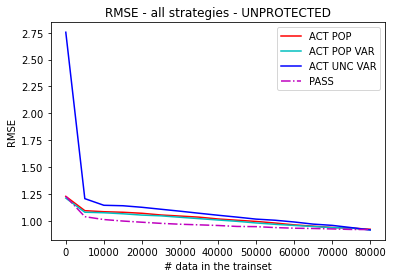

In [76]:
plt.plot(data_big,rmse_al_unpro,'r')
plt.plot(data_big,rmse_al_unpro_popvar,'c')
plt.plot(data_big,rmse_al_unpro_unvar,'b')
plt.plot(data_big,rmse_ran_unpro,'m-.')
# plt.plot(data_big,rmse_ran_popvar,'c.')
# plt.plot(data_big,rmse_ran_unvar,'b.')


# plt.axis([0,20000,0.5,2.0])
plt.title('RMSE - all strategies - UNPROTECTED')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['ACT POP','ACT POP VAR', 'ACT UNC VAR', 'PASS', 'PASS POP VAR', 'PASS UN VAR'], loc='upper right')
# plt.show()
plt.savefig('./figures/july9/RMSE - all - big gap3.png')


### RMSE PROs & UNPROs 

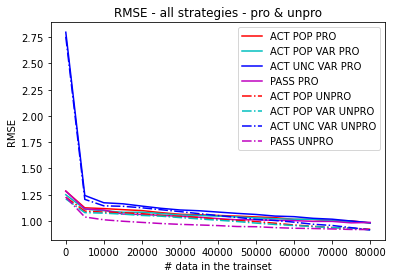

In [77]:
plt.plot(data_big,rmse_al_pro,'r')
plt.plot(data_big,rmse_al_pro_popvar,'c')
plt.plot(data_big,rmse_al_pro_unvar,'b')
plt.plot(data_big,rmse_ran_pro,'m')

plt.plot(data_big,rmse_al_unpro,'r-.')
plt.plot(data_big,rmse_al_unpro_popvar,'c-.')
plt.plot(data_big,rmse_al_unpro_unvar,'b-.')
plt.plot(data_big,rmse_ran_unpro,'m-.')


# plt.axis([0,20000,0.5,2.0])
plt.title('RMSE - all strategies - pro & unpro')
plt.xlabel('# data in the trainset')
plt.ylabel('RMSE')
plt.legend(['ACT POP PRO', 'ACT POP VAR PRO', 'ACT UNC VAR PRO', 'PASS PRO',
            'ACT POP UNPRO', 'ACT POP VAR UNPRO', 'ACT UNC VAR UNPRO', 'PASS UNPRO'], loc='upper right')
# plt.show()
plt.savefig('./figures/july9/RMSE - all - big gap4.png')


## RMSE Difference - all strategies

We know that the RMSE is higher for the protected group among all methods. Therefore there should be a difference between the rmse of the pro and unpro group. If the difference is positive, it means that the RMSE of the protected is unfairly higher. And if the value is negative, it means that the RMSE of the unprotected group is higher. The closer it is to 0, the better. It means that both groups have similar RMSEs.

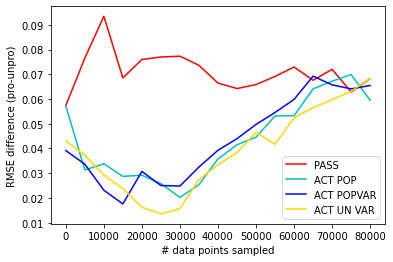

In [79]:
rmse_diff_pop = [a-b for a, b in zip(rmse_al_pro,
                                     rmse_al_unpro)]

rmse_diff_popvar = [a-b for a, b in zip(rmse_al_pro_popvar,
                                        rmse_al_unpro_popvar)]

rmse_diff_unvar = [a-b for a, b in zip(rmse_al_pro_unvar,
                                       rmse_al_unpro_unvar)]


rmse_diff_ran = [a-b for a, b in zip(rmse_ran_pro,
                                     rmse_ran_unpro)]

# rmse_diff_ = [a-b for a, b in zip(rmse_ran_pro_unvar,
#                                      rmse_ran_unpro_unvar)]

# rmse_diff = [a-b for a, b in zip(rmse_ran_pro,
#                                      rmse_ran_unpro)]

# plt.plot(data_big,rmse_diff,'r-.')
# plt.plot(data_big,rmse_diff_,'r.')
plt.plot(data_big,rmse_diff_ran,'r')
plt.plot(data_big,rmse_diff_pop,'c')
plt.plot(data_big,rmse_diff_popvar,'b')
plt.plot(data_big,rmse_diff_unvar,'gold')

plt.xlabel('# data points sampled')
plt.ylabel('RMSE difference (pro-unpro)')

# plt.legend(['ran2', 'ran1', 'ran', 'pop', 'popvar', 'uncertainty var'], loc='upper right')
plt.legend(['PASS', 'ACT POP', 'ACT POPVAR', 'ACT UN VAR'], loc='best')
plt.savefig('./figures/july9/RMSE DIFF - all.png')

In the random method, the RMSE difference is a lot higher than all the other methods while the general RMSE is lower in the aggregated manner.
The pop and popvar methods are pretty simialar and have similar trends. The best method is the uncertainty based method which gives the lower difference between two groups! But why?

As we collect more data, since the data is already biased, the error gets higher and higher. Would this support that data minimization actually helps fairness, not hurts?

In the uncertainty based method, we get the lowest difference!In this method we sample from the data that has the highest uncetainty (high variance in rating). Why does adding items with high rating variance help balance the RMSE? Are we considering diversity? Are we considering opposing rating of users, therefore we don't focus on the ratings of one group that is more aligned together?

Even collecting the popular items is contributing to the balance in RMSE! So, just data minimization might just be the case, or balancing the collected data on different subgroups!

- How many of the sampled data(user,item,rating) at each iteration is rated by pro users and unpro users? For each collected sample, count the number of pro and unpro users.

## Value Unfairness comparision

ValueError: x and y must have same first dimension, but have shapes (17,) and (3,)

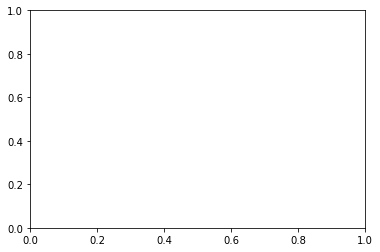

In [71]:
plt.plot(data_big,vu_al,'c')
plt.plot(data_big,vu_al_popvar,'b')
plt.plot(data_big,vu_al_unvar,'gold')
# plt.plot(data_big,vu_ran,'m-.')
plt.plot(data_big,vu_ran_popvar,'r')
# plt.plot(data_big,vu_ran_unvar,'b-.')


# plt.axis([0,20000,0.5,2.0])
plt.title('value unfairness - all strategies')
plt.xlabel('# data in the trainset')
plt.ylabel('value unfairness')
plt.legend(['ACT POP','ACT POP VAR', 'ACT UNC VAR', 'PASS', 'PASS POP VAR', 'PASS UN VAR'], loc='best')
# plt.show()
plt.savefig('./figures/july14/value unfairness - all.png')


## ACCURACY VS FAIRNESS

In [135]:
def rmse_unfairness(fa_lable,
                    ran_er, ran_fa,
                    pop_er, pop_fa,
                    popvar_er, popvar_fa,
                    uncvar_er, uncvar_fa,
                    fig_path):

    lbls = data_big
    fa = fa_lable.split()
    fa = (fa[0][0]+fa[1][0]).upper()

    fig, ax = plt.subplots()
    # popularity variance
    ax.scatter(ran_er, ran_fa, label='PASS %s'%fa)

    # popualrity
    ax.scatter(pop_er, pop_fa, label='POP %s'%fa)

    # sqrt(popularity) * variance
    ax.scatter(popvar_er, pop_fa, label='POP VAR %s'%fa)

    # uncertainty variance
    ax.scatter(uncvar_er, uncvar_fa, label='UNC VAR %s'%fa)

#     # add the labels
#     for i, txt in enumerate(lbls):
#         ax.annotate(i, (rmse_al_unvar[i], vu_al_unvar[i]))
#     #     ax.annotate(txt, (rmse_al_unvar[i], vu_al_unvar[i]))

    ax.legend(loc='best')
    ax.grid(True)
    ax.set_xlabel('RMSE')
    ax.set_ylabel('%s'%fa_lable.upper())
    ax.set_title('%s vs RMSE'%fa_lable.upper())

    plt.savefig(fig_path)


### accuracy vs value unfairness

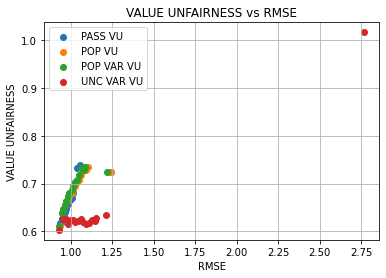

In [136]:
rmse_unfairness('value unfairness',
                rmse_ran, vu_ran,
                rmse_al, vu_al,
                rmse_al_popvar, vu_al_popvar,
                rmse_al_unvar, vu_al_unvar,
               './figures/july14/rmse vs vu.png')

### accuracy vs absolute unfairness

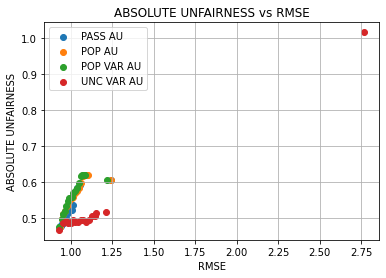

In [137]:
rmse_unfairness('absolute unfairness',
                rmse_ran, au_ran,
                rmse_al, au_al,
                rmse_al_popvar, au_al_popvar,
                rmse_al_unvar, au_al_unvar,
               './figures/july14/rmse vs au.png')

### accuracy vs over-estimation unfairness

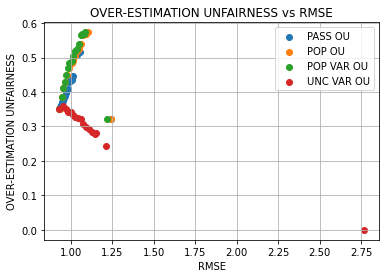

In [138]:
rmse_unfairness('over-estimation unfairness',
                rmse_ran, ou_rand,
                rmse_al, ou_al,
                rmse_al_popvar, ou_al_popvar,
                rmse_al_unvar, ou_al_unvar,
               './figures/july14/rmse vs ou.png')

### accuracy vs under-estimation unfairness

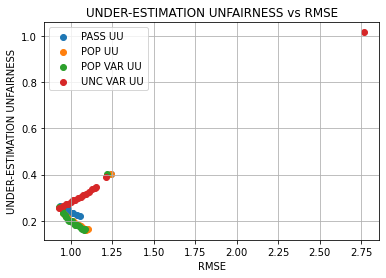

In [139]:
rmse_unfairness('under-estimation unfairness',
                rmse_ran, uu_rand,
                rmse_al, uu_al,
                rmse_al_popvar, uu_al_popvar,
                rmse_al_unvar, uu_al_unvar,
               './figures/july14/rmse vs uu.png')

### accuracy vs parity unfairness (nonparity)

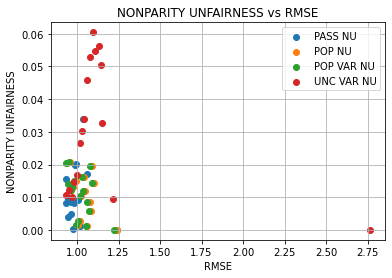

In [140]:
rmse_unfairness('nonparity unfairness',
                rmse_ran, np_ran,
                rmse_al, np_al,
                rmse_al_popvar, np_al_popvar,
                rmse_al_unvar, np_al_unvar,
               './figures/july14/rmse vs nonparity.png')

random plots are full of fluctuations predictably. The solid lines show the active learning strategies and the dotted line is the random state.

# **Item Popularity**

In [154]:
orig_itempop = {}
pro_itempop = {}
unpro_itempop = {}

for item, itspop in df.groupby('item'):
#     print(item, itspop['user'].tolist())
    users = itspop['user'].tolist()
    
    # calcualte the commonalities of 
    # this user with the pro and then with the unpro user lists
    
    itspros = set(users).intersection(set(pro_users))
    itsunpro = set(users).intersection(set(unpro_users))
    
    # the first three elements should be exactly the same
#     print(len(itspop), len(users),
#           len(set(users)), len(itspros), len(itsunpro))
    
    orig_itempop[item] = len(itspop)
    pro_itempop[item] = len(itspros)
    unpro_itempop[item] = len(itsunpro)
    

from collections import OrderedDict

# order the dictionary
orig_itempop_s = OrderedDict(sorted(orig_itempop.items(), key=lambda x:x[1], reverse=True))


In [155]:
innerid_to_itemid = {idx:itemid for idx,
                     itemid in enumerate(orig_itempop_s.keys())}
# to_itemid = {}
itemid_to_innerid = {itemid:idx for idx,
                     itemid in enumerate(orig_itempop_s.keys())}

In [156]:
# innerid_to_itemid
# orig_itempop_s

In [157]:
orig_pro_itempop_s = []
orig_unpro_itempop_s = []

for innerid in innerid_to_itemid.keys():

    itemid = innerid_to_itemid[innerid]
    
    orig_pro_itempop_s.append(pro_itempop[itemid])
    orig_unpro_itempop_s.append(unpro_itempop[itemid])
    

In [158]:
# orig_pro_itempop_s[:5]
# orig_unpro_itempop_s[:5]
# orig_itempop_s

## plotting the item popularity

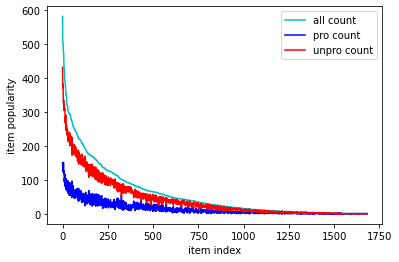

In [159]:
plt.plot(innerid_to_itemid.keys(), orig_itempop_s.values(), 'c')
plt.plot(innerid_to_itemid.keys(), orig_pro_itempop_s, 'b')
plt.plot(innerid_to_itemid.keys(), orig_unpro_itempop_s, 'r')

plt.xlabel('item index')
plt.ylabel('item popularity')
plt.legend(['all count', 'pro count', 'unpro count'], loc='best')
plt.savefig('./figures/july6/item popularity.png')

how many of the ratings is contributed by each group?

## plotting the long tail

for every item id, how many ratings does it have, how many from the protected and how many from the unprotected users?

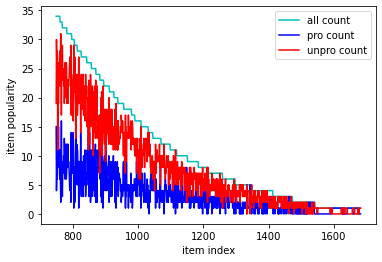

In [160]:
plt.plot(list(innerid_to_itemid.keys())[750:], list(orig_itempop_s.values())[750:], 'c')
plt.plot(list(innerid_to_itemid.keys())[750:], orig_pro_itempop_s[750:], 'b')
plt.plot(list(innerid_to_itemid.keys())[750:], orig_unpro_itempop_s[750:], 'r')

plt.xlabel('item index')
plt.ylabel('item popularity')
plt.legend(['all count', 'pro count', 'unpro count'], loc='best')
plt.savefig('./figures/july6/item popularity2.png')